## MNIST DCGAN

We're going to create a GAN that generates synthetic handwritten digits.

Code used and modifed from:
- https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_dcgan.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install keras==2.2.4
!pip install tensorflow==1.13.1

     |████████████████████████████████| 317kB 6.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


     |████████████████████████████████| 92.5MB 31kB/s 
     |████████████████████████████████| 3.2MB 31.7MB/s 
     |████████████████████████████████| 368kB 38.3MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [2]:
import keras; print(keras.__version__)
import tensorflow; print(tensorflow.__version__)

2.2.4
1.13.1


In [3]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')
#K.common.set_image_dim_ordering('th')

# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 10

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5

print("Y")
X_train = X_train[:, np.newaxis, :, :]
print("Y")

# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
print("Y")

# Make our Generator Model
generator = Sequential()
print("Y")

# Transforms the input into a 7 × 7 128-channel feature map
generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
print("Y")

# Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
print(generator.summary())
generator.compile(loss='binary_crossentropy', optimizer=adam)
print("Y")

# Make our Discriminator Model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
print("Y")

# Creating the Adversarial Network. We need to make the Discriminator weights
# non trainable. This only applies to the GAN model.
discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
print("Y")

# Our Discriminator and Generator Losses
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/drive/My Drive/GAN MNIST/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/dcgan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('/content/drive/My Drive/GAN MNIST/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('/content/drive/My Drive/GAN MNIST/dcgan_discriminator_epoch_%d.h5' % epoch)

Y
Y
Instructions for updating:
Colocations handled automatically by placer.
Y
Y
Y
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
____________________________________________________________

## Train our GAN and Plot the Synthetic Image Outputs 

After each consecutive Epoch we can see how synthetic images being improved 

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [22:28<00:00,  2.88s/it]


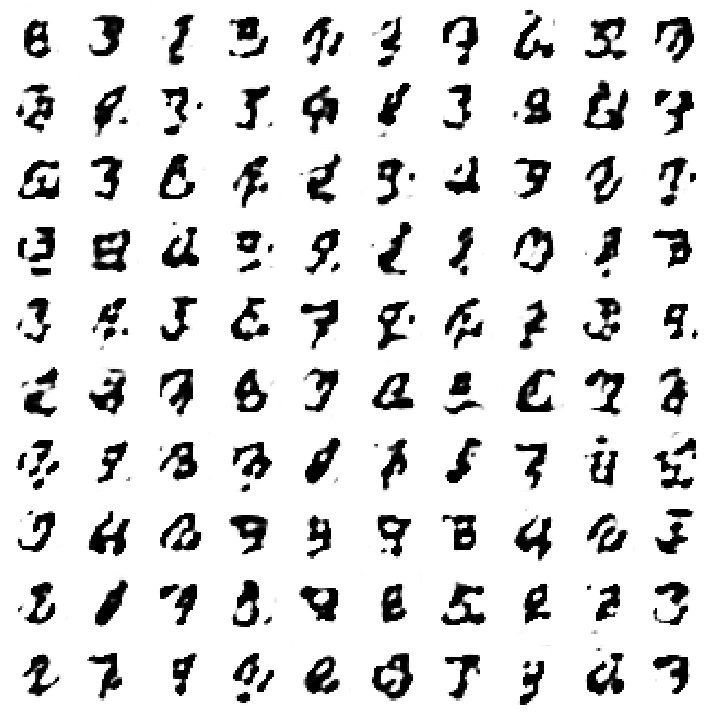

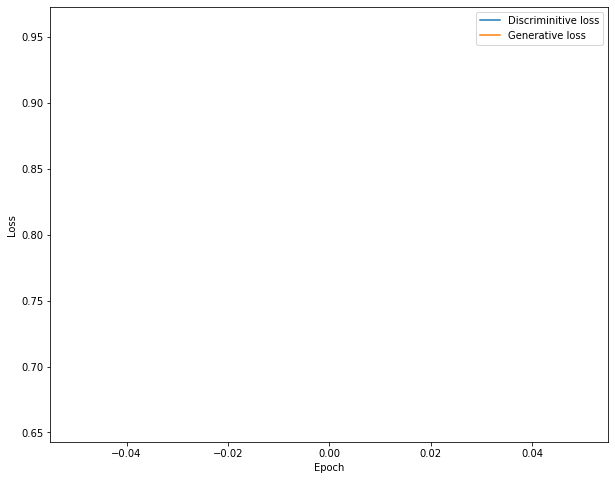

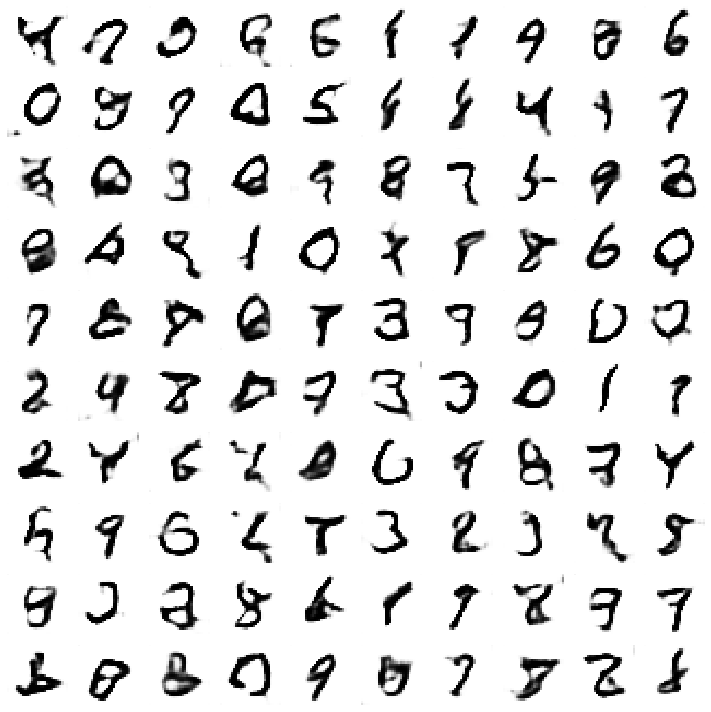

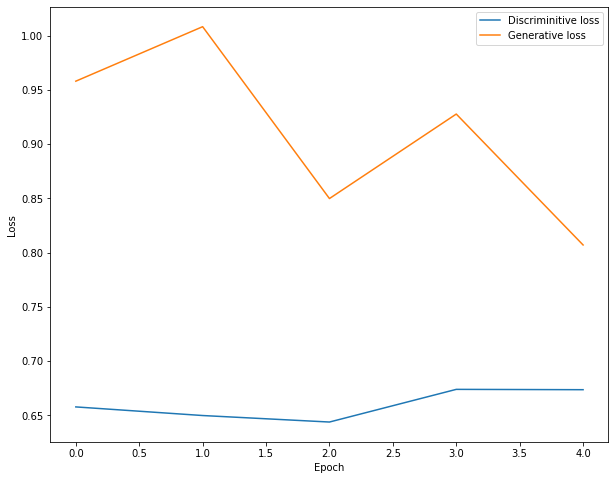

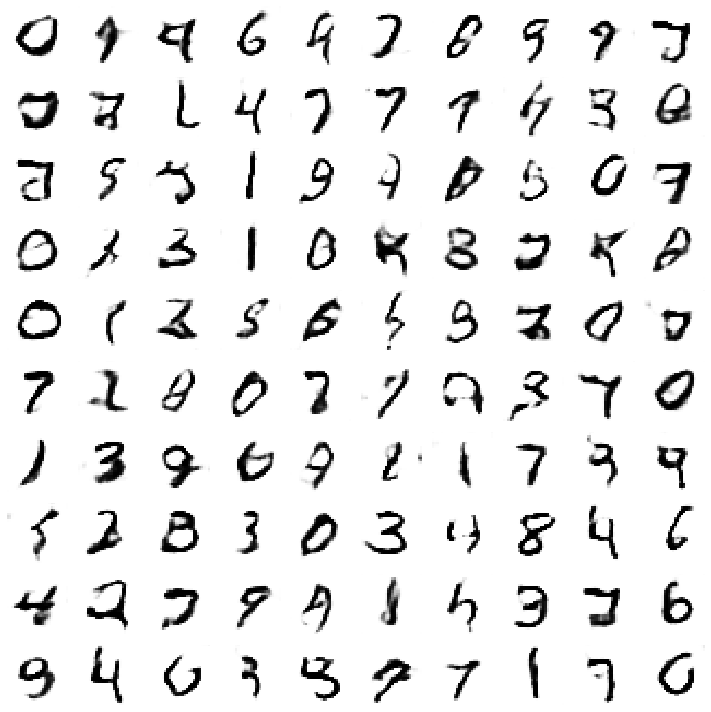

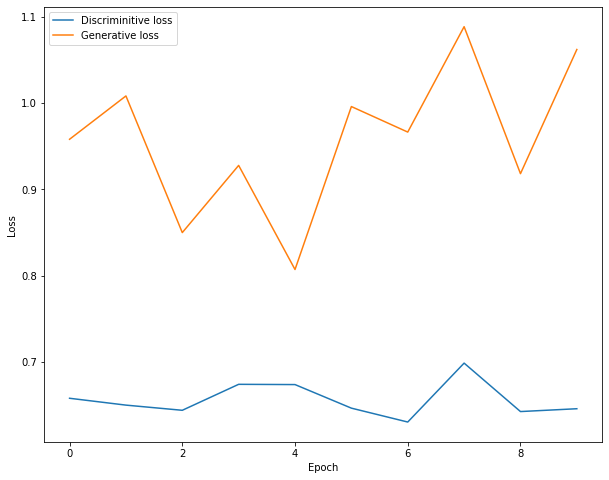

In [4]:
epochs = 10
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)
        
        # Plot losses from every epoch
        plotLoss(e)
        saveModels(e)

